### Understanding the Fourier Transform

<img src="./fourier.png" width="10%">

I came across the fourier transform while writing software in different contexts. 
I was fascinated by the power of this method but I did not understood how it works. 
This notebook contains all the work we have been doing to try to understand how
the FT works.

First, the FT is a mathematical method to find the contributions of simple signals 
(sin/cos) to a more complex signal.

$$
F(\frac{n}{NT}) = \frac{1}{N} 
\sum_{k=0}^{N-1} m(kT) e^{-j\frac{2\pi n k}{N}} \hspace{1cm} n = 0,1, \cdots N-1
$$

Without digging into the formula details, let's define the variables. 

$N$ is the number of samples we have in the window we are analyzing. 

$T$ is the period of sampling ($T = \frac{1}{f}$) where $f$ is the sampling frequency. 

$n$ is the index of the frequency we are analyzing. 

$m(kT)$ yields the value of the sample k for a particular frequency.

What the method does is to resolve the equation for different frequencies. Those
frequencies come from the value of $n$, the number of samples $N$, and the sampling
frequency (remember, $N = \frac{1}{f}$).



In [1]:
from __future__ import print_function, division

%matplotlib inline

import thinkdsp
import thinkplot

import numpy as np

#import warnings
#warnings.filterwarnings('ignore')

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
from IPython.display import display

In [2]:
# Preparemos la funcion continue que utiliza 
one_sig = thinkdsp.SinSignal(freq=2, amp=4, offset=0)   # 4*sen(2t)
two_sig = thinkdsp.SinSignal(freq=6, amp=2, offset=0)   # 2*sen(6t)

0 0.0 0.0
1 0.05 4.25325404176
2 0.1 2.6286555606
3 0.15000000000000002 2.6286555606
4 0.2 4.25325404176
5 0.25 1.22464679915e-15
6 0.30000000000000004 -4.25325404176
7 0.35000000000000003 -2.6286555606
8 0.4 -2.6286555606
9 0.45 -4.25325404176
10 0.5 -2.44929359829e-15
11 0.55 4.25325404176
12 0.6000000000000001 2.6286555606
13 0.65 2.6286555606
14 0.7000000000000001 4.25325404176
15 0.75 3.67394039744e-15
16 0.8 -4.25325404176
17 0.8500000000000001 -2.6286555606


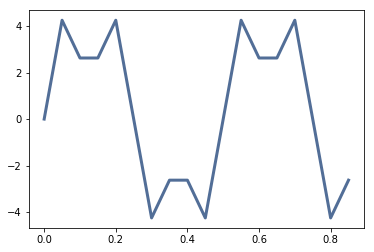

In [38]:
mix           = one_sig + two_sig
n_samples     = 18
sample_freq   = 20
sample_period = 1/fm
_duration     = sample_period * n_samples
wave = mix.make_wave(duration=_duration, start=0, framerate=sample_freq)
wave.plot()

# This is the array of samples (n_samples size) in the TIME domain
a_samples_time = [i*sample_period for i in range(n_samples)]
    
# Let's evaluate those to validate what we have in the paper
a_samples_values = mix.evaluate(a_samples_time)

for i, (one, two) in enumerate(zip(a_samples_time, a_samples_values)):
    print(i, one, two)
    

                                      


Everything is pretty clear with the exception of the evaluate function.
What are we doing there? This is the code:

From the DSP book:

`
 def evaluate(self, ts):
        phases = PI2 * self.freq * ts + self.offset
        ys = self.amp * self.func(phases)
        return ys
`

Let’s unwind this function one step at time:

    1. self.freq is frequency in cycles per second, and each element of ts is a time in seconds, so their product is the number of cycles since the start time.

    2. PI2 is a constant that stores 2π. Multiplying by PI2 converts from cycles to phase. You can think of phase as “cycles since the start time” expressed in radians. Each cycle is 2π radians.

    3. self.offset is the phase when t = 0. It has the effect of shifting the signal left or right in time.

    4. If self.func is np.sin or np.cos, the result is a value between −1 and +1.

    5. Multiplying by self.amp yields a signal that ranges from -self.amp to +self.amp.

So, before applying the value to the function to get our value, we convert
from seconds to cycles (since the start of time) in radiands. 

We are just doing a units conversion to radians (Angular measure). sin() an cos()
perate in those units (?).

Ok, now we can carry on. The continuous function we are evaluting
matches the one in the paper.

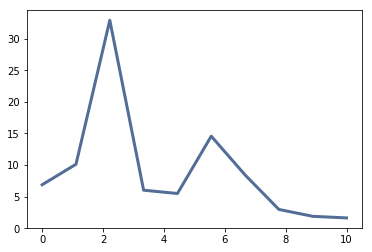

In [73]:
spec = wave.make_spectrum()
spec.plot()

We can by computing the spectrum that our wave has two dominating frequencies (2 and 6). That matches what we see in the paper. But let's go lower level and apply the FFT ourselves.


The `make_spectrum` code looks like:

```
 def make_spectrum(self, full=False):
        """Computes the spectrum using FFT.

        returns: Spectrum
        """
        n = len(self.ys)
        d = 1 / self.framerate

        if full:
            hs = np.fft.fft(self.ys)
            fs = np.fft.fftfreq(n, d)
        else:
            hs = np.fft.rfft(self.ys)
            fs = np.fft.rfftfreq(n, d)

        return Spectrum(hs, fs, self.framerate, full)
```

the parameter full is False so we compute this:

```
 hs = np.fft.rfft(self.ys)
 fs = np.fft.rfftfreq(n, d)
```

notice that hs is the array of amplitudes and fs is the array
of frequencies. We'll explore this in the next cell.

Let's run that manually:


In [83]:
#This function computes the one-dimensional *n*-point discrete Fourier
#Transform (DFT) of a real-valued array by means of an efficient algorithm
#called the Fast Fourier Transform (FFT).
print("--- hs first")
hs = np.absolute(np.fft.rfft(a_samples_values))
print(len(a_samples_values), len(hs))
print(hs)
print(hs/20)

print("---- fs now")
fs = np.absolute(np.fft.rfftfreq(len(a_samples_values), sample_period ))
print(fs)


--- hs first
18 10
[  6.8819096   10.12745205  32.94322445   6.01500955   5.49224861
  14.57359036   8.43294503   2.96632111   1.87893177   1.62459848]
[ 0.34409548  0.5063726   1.64716122  0.30075048  0.27461243  0.72867952
  0.42164725  0.14831606  0.09394659  0.08122992]
---- fs now
[  0.           1.11111111   2.22222222   3.33333333   4.44444444
   5.55555556   6.66666667   7.77777778   8.88888889  10.        ]


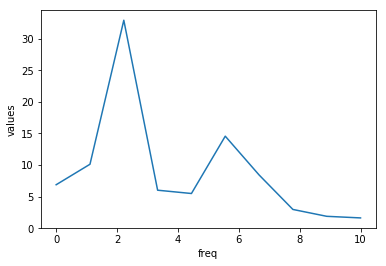

In [89]:
# This is what we got when we run make_spectrum() above. Cool.
plt.plot(fs, hs)
plt.ylabel('values')
plt.xlabel('freq')
plt.show()